# Imports

In [1]:
#Needed for reading the data
import h5py as h5
#Needed for checking file existence
import os 
#Needd for array handling slicing
import numpy as np
#Needed for plotting
import matplotlib.pyplot as plt


# Custom imports (i.e. own scripts)

In [2]:
None

# Path to Data

In [3]:
#Tip an absolute path is useful to keep
#script working everywhere on your PC
path     = '/home/cneijssel/Desktop/RLOF_test/First_Solar/'
filename = 'COMPASOutput.h5'

# Reading the Data h5file

<a href="../1_H5files/1_ReadingH5Files.html">
Loading a COMPASOutput.h5 file and basic h5py syntax.
</a>
 


In [4]:
if not  os.path.isfile(path+filename):
    raise ValueError("h5 file not found. Wrong path given?")
elif os.path.isfile(path+filename):
    Data  = h5.File(path+filename)

# Slicing Data with booleans

The classic way of slicing data is using for loops#
I.e. you have a list of values. You go through the list
and if the value meets some criterias you add them to another list


In [5]:
DCOs = Data['doubleCompactObjects']

M1   = DCOs['M1'][...].squeeze()
M2   = DCOs['M2'][...].squeeze()
Mtot = np.add(M1 , M2)
newList = []
for value in Mtot:
    if value > 20:
        newList.append(value)

The problem is that a for loop can take long if the array is millions
of entries long. Secondly if you want to know the separations of systems
with total masses more than 20Msun you need to keep defining lists to extend to
and expand the for loop. Instead you can also use masks.

A mask is simply a array of True and false values.
If you slice the data in a mask it immediately gives you the reduced list.
Note that it is best to transform any list in np.arrays. 

We mention this here because from this point on we mostly use this form
of data reduction/slicing



In [6]:
#A file has a column a and b (OF THE SAME LENGTH!!)
a = np.array([0,1,2,3,4,5])
b = np.array(['a','b','c','d','e','f'])
#Give me all the letters in b for which the values in a is larger than 3

mask = a >3
print(mask)

[False False False False  True  True]


In [7]:
bNew = a[mask]
print(bNew)

[4 5]


In the case to get the primary masses M1 of which the total masses

are bigger than 20 solar masses and the secondary less massive than 10 solar masses

In [8]:
# Remember masks need to be the same length
maskTotalMass = Mtot > 20
maskSecondary = M2   < 10
mask          = maskSecondary & maskTotalMass
#If instead of both true you want one or the other be true
#mask          = maskSecondary | maskTotalMass

M1interest    = M1[mask]
print(np.min(M1interest))
print(np.max(Mtot[mask]))

10.4866
21.5184


# Using seeds to slice between datafiles

As mentioned in 

<a href="../1_H5files/3_DescriptionFilesColumns.html">
Files and Columns in COMPASOutput.h5
</a>

The COMPAS output has different files relating to different
topics of interest. Sometimes we might need to combine the info of different files.

For example what are the initial masses of systems that became binary black holes.

This means we need to get the parameters from the Data['systems'] group

based on a criteria in the Data['doubleCompactObjects'] group

The variable that links the parameters per system is its seed.

Hence the earlier question becomes

step1 - what are the seeds of systems that became binary black holes

step2 - what are the initial masses of the seeds of step 1


### Step 1

In [9]:
#get the info you want from the double compact objects file
DCOs          = Data['doubleCompactObjects']
typePrimary   = DCOs['stellarType1'][...].squeeze()
typeSecondary = DCOs['stellarType2'][...].squeeze()
seeds         = DCOs['seed'][...].squeeze()

#create the mask for binary black holes (stellartype == 14)
maskBBH       = (typePrimary == 14) & (typeSecondary == 14)
seedsBBH      = seeds[maskBBH]

Before we do step two it is important to realise that the seeds have a specific order
in the output file.

If we evolve 10 systems then the seeds array in the systems file looks like

If only seeds 3 4 and 9 became a DCO (double compact object)

This has to do with the fact that the COMPAS popsynth 

every time it evolves a system it writes the output to every file

before it moves to the next system, giving them the same order

The main useful thing with regards to slicing is that the parameters linked to the
seeds are also ordered.

Hence if we apply a mask seedsSystems to get seedsDCOs we also get all the parameters ordered 


### Step 2

In [10]:
#get a mask which recovers the seeds in the systems file
#which become BBHs. I want the mask and not the seeds, because 
#If I have the mask I can get any other parameter from the systems file

#define initial parameters file for better readability
initialParameters = Data['systems']
seedsInitial      = initialParameters['SEED']


#a useful numpy trick is numpy.in1d(array1, array2)
#this returns a mask of elements in array1 that are in array 2
maskBBHinitial    = np.in1d(seedsInitial, seedsBBH)

#if we apply this mask to any array of the initial systems
#we get the initial parameters of BBHs in the same order as
#the final parameters in the DCO file
M1initial         = initialParameters['mass1'][...].squeeze()[maskBBHinitial]
M2initial         = initialParameters['mass2'][...].squeeze()[maskBBHinitial]
MtotInitial       = np.add(M1initial, M2initial)

#contract a few lines to get final BBH masses
MtotFinal         = DCOs['M1'][...].squeeze()[maskBBH] +\
                    DCOs['M2'][...].squeeze()[maskBBH]

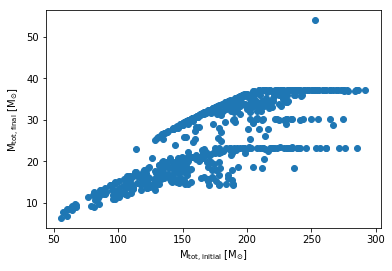

In [11]:
#Make a cool scatterplot
fig, axes = plt.subplots(1,1)
axes.scatter(MtotInitial, MtotFinal)
axes.set_xlabel(r'$\rm M_{tot, initial}\ [M_{\odot}]$')
axes.set_ylabel(r'$\rm M_{tot, final}\ [M_{\odot}]$')
plt.show()
plt.close()

# Not all files have only 1 line per SEED!

Each system can only be created once or form a DCO once.

Hence these files have, if at all, each seed printed only once

However, a binary can experience multiple supernovae or mass transfer episodes

The trick of slicing remains the same, but the arrays are no longer the same length.


For example what where all the masses of the star before supernova (SN), before they became a BBH

In [12]:
#reuse the seeds that became BBH and get the maskSeedSupernova

SN          = Data['supernovae']
seedsSN     = SN['randomSeed'][...].squeeze()
maskSeedBBH =  np.in1d(seedsSN, seedsBBH)

#mass before supernove
massBeforeSN = SN['MassStarSN'][...].squeeze()[maskSeedBBH]

print('nr BBHs = %s, nr lines in SN=%s' %(len(seedsBBH), len(massBeforeSN)))

nr BBHs = 641, nr lines in SN=1282


In this case the above makes perfect sense. 

For every BBH binary there have to be 2 SNe so I get double the amount of lines.

We can further reduce it to get the same number of lines,
so an event that can happen only once per binary. For example the primary goes SN

In [13]:
maskPrimary         = SN['whichStar'][...].squeeze() ==1

#keep track of length of masks when combining
maskPrimaryBeforeSN = maskSeedBBH & maskPrimary
#not possible, because massBeforeSN already reduced ;
#maskPrimaryBeforeSN = massBeforeSN & maskPrimary

massPrimaryBeforeSN = SN['MassStarSN'][...].squeeze()[maskPrimaryBeforeSN]

print('nr BBHs = %s, nr lines in SN=%s' %(len(seedsBBH), len(massPrimaryBeforeSN)))

nr BBHs = 641, nr lines in SN=641


In [14]:
#I am done here see ya!
Data.close()